# Import Library

In [8]:
import os
import shutil
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Lambda, LSTM
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Preprocessing data

In [ ]:
video_dataset_path = r"C:\Users\ACER\Downloads\dataset\datamart\s2"
output_frames_path =  r"C:\Users\ACER\Downloads\dataset\frames_final"
face_output_frames_path =  r"C:\Users\ACER\Downloads\dataset\face_frames_final"
split_output_path = r"C:\Users\ACER\Downloads\dataset\split_final"

## Ekstrak Frame

In [ ]:
def extract_frames(video_dataset_path, output_frames_path):
    if not os.path.exists(output_frames_path):
        os.makedirs(output_frames_path)

    # Iterasi melalui folder kelas di dataset
    for class_folder in os.listdir(video_dataset_path):
        class_path = os.path.join(video_dataset_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        print(f"Processing class: {class_folder}")

        # Buat folder output untuk kelas jika belum ada
        output_class_path = os.path.join(output_frames_path, class_folder)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        # Iterasi melalui video di folder kelas
        for video_file in os.listdir(class_path):
            video_path = os.path.join(class_path, video_file)
            if not video_file.endswith(('.mp4', '.avi', '.mkv', '.mov')):
                continue

            print(f"\tExtracting frames from video: {video_file}")

            # Buat folder untuk video jika belum ada
            video_name = os.path.splitext(video_file)[0]
            output_video_path = os.path.join(output_class_path, video_name)
            if not os.path.exists(output_video_path):
                os.makedirs(output_video_path)

            # Baca video dan ekstrak frame
            cap = cv2.VideoCapture(video_path)
            frame_count = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Simpan setiap frame
                frame_filename = os.path.join(output_video_path, f"frame_{frame_count:04d}.jpg")
                cv2.imwrite(frame_filename, frame)
                frame_count += 1

            cap.release()
            print(f"\tExtracted {frame_count} frames from video: {video_file}")

if __name__ == "__main__":
    extract_frames(video_dataset_path, output_frames_path)

Processing class: anger
	Extracting frames from video: anger_1.mp4
	Extracted 228 frames from video: anger_1.mp4
	Extracting frames from video: anger_2.mp4
	Extracted 228 frames from video: anger_2.mp4
	Extracting frames from video: anger_4.mp4
	Extracted 600 frames from video: anger_4.mp4
	Extracting frames from video: anger_5.mp4
	Extracted 226 frames from video: anger_5.mp4
	Extracting frames from video: anger_6.mp4
	Extracted 226 frames from video: anger_6.mp4
	Extracting frames from video: anger_7.mp4
	Extracted 301 frames from video: anger_7.mp4
Processing class: fear
	Extracting frames from video: fear_1.mp4
	Extracted 228 frames from video: fear_1.mp4
	Extracting frames from video: fear_2.mp4
	Extracted 228 frames from video: fear_2.mp4
	Extracting frames from video: fear_3.mp4
	Extracted 228 frames from video: fear_3.mp4
	Extracting frames from video: fear_4.mp4
	Extracted 301 frames from video: fear_4.mp4
	Extracting frames from video: fear_5.mp4
	Extracted 226 frames from vi

In [ ]:
def print_frame_statistics(output_frames_path):
    total_frames = 0
    class_frame_counts = {}

    # Iterasi melalui folder kelas di folder output
    for class_folder in os.listdir(output_frames_path):
        class_path = os.path.join(output_frames_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        class_frame_count = 0

        # Iterasi melalui folder video di folder kelas
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            if not os.path.isdir(video_path):
                continue

            # Hitung jumlah frame dalam folder video
            frame_count = len([f for f in os.listdir(video_path) if f.endswith('.jpg')])
            class_frame_count += frame_count

        class_frame_counts[class_folder] = class_frame_count
        total_frames += class_frame_count

    print("Frame Statistics:")
    print(f"Total Dataset: {total_frames}")
    for class_name, frame_count in class_frame_counts.items():
        print(f"Class {class_name}: {frame_count} frames")

print_frame_statistics(output_frames_path)

Frame Statistics:
Total Dataset: 10274
Class anger: 1809 frames
Class fear: 1437 frames
Class happy: 1731 frames
Class neutral: 1887 frames
Class sad: 1531 frames
Class surprised: 1879 frames


## ekstrak wajah

In [ ]:
def extract_faces_from_all_frames(output_frames_path, face_output_frames_path):
    if not os.path.exists(face_output_frames_path):
        os.makedirs(face_output_frames_path)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Iterasi melalui folder kelas di folder output frames
    for class_folder in os.listdir(output_frames_path):
        class_path = os.path.join(output_frames_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        print(f"Processing class: {class_folder}")

        class_face_path = os.path.join(face_output_frames_path, class_folder)
        if not os.path.exists(class_face_path):
            os.makedirs(class_face_path)

        # Iterasi melalui folder video di folder kelas
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            if not os.path.isdir(video_path):
                continue

            video_face_path = os.path.join(class_face_path, video_folder)
            if not os.path.exists(video_face_path):
                os.makedirs(video_face_path)

            # Iterasi melalui frame di folder video
            for frame_file in os.listdir(video_path):
                if not frame_file.endswith('.jpg'):
                    continue

                frame_path = os.path.join(video_path, frame_file)
                frame = cv2.imread(frame_path)
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

                for i, (x, y, w, h) in enumerate(faces):
                    face = frame[y:y+h, x:x+w]
                    face_filename = os.path.join(video_face_path, f"{os.path.splitext(frame_file)[0]}_face_{i}.jpg")
                    cv2.imwrite(face_filename, face)

In [ ]:
extract_faces_from_all_frames(output_frames_path, face_output_frames_path)

Processing class: anger
Processing class: fear
Processing class: happy
Processing class: neutral
Processing class: sad
Processing class: surprised


In [ ]:
print_frame_statistics(face_output_frames_path)

Frame Statistics:
Total Dataset: 10322
Class anger: 1855 frames
Class fear: 1411 frames
Class happy: 1697 frames
Class neutral: 1887 frames
Class sad: 1824 frames
Class surprised: 1648 frames


## SPLIT

In [ ]:
def split_data(source, destination, train_size=0.7, val_size=0.2):
    """
    Fungsi untuk membagi data menjadi train, validation, dan test set dengan proporsi 70%, 20%, dan 10%.
    """
    # Pastikan direktori tujuan ada, jika tidak, buat
    if not os.path.exists(destination):
        os.makedirs(destination)

    # Dapatkan semua sub-direktori dalam direktori sumber
    classes = [d for d in os.listdir(source) if os.path.isdir(os.path.join(source, d))]
    for cls in classes:
        class_dir = os.path.join(source, cls)
        videos = [d for d in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, d))]

        for video in videos:
            video_dir = os.path.join(class_dir, video)
            frames = [f for f in os.listdir(video_dir) if f.endswith('.jpg')]

            # Membagi dataset menjadi train, validation, dan test
            train, temp = train_test_split(frames, test_size=0.3, random_state=42)  # 30% untuk val + test
            val, test = train_test_split(temp, test_size=1/3, random_state=42)  # 1/3 dari 30% untuk test

            # Fungsi untuk menyalin frame ke direktori yang sesuai
            def copy_files(files, type_):
                dest_dir = os.path.join(destination, type_, cls, video)
                if not os.path.exists(dest_dir):
                    os.makedirs(dest_dir)
                for file in files:
                    shutil.copy(os.path.join(video_dir, file), os.path.join(dest_dir, file))

            # Salin file ke direktori yang sesuai
            copy_files(train, 'train')
            copy_files(val, 'val')
            copy_files(test, 'test')


# Memanggil fungsi untuk membagi dataset
split_data(face_output_frames_path, split_output_path)

# Inception-Resnet

In [ ]:
img_size = (299, 299)
batch_size = 32
num_classes = len(os.listdir(train_dir))

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7212 images belonging to 6 classes.
Found 2060 images belonging to 6 classes.
Found 1050 images belonging to 6 classes.


In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False

global_avg_pool = GlobalAveragePooling2D()(base_model.output)
dropout_layer = Dropout(0.5)(global_avg_pool)
output_layer = Dense(num_classes, activation='softmax')(dropout_layer)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 54,345,958 (207.31 MB)

 Trainable params: 9,222 (36.02 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='model.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_callback]
)

C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1901 - loss: 1.9564
Epoch 1: val_accuracy improved from -inf to 0.38206, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1166s 6s/step - accuracy: 0.1901 - loss: 1.9561 - val_accuracy: 0.3821 - val_loss: 1.6296
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2646 - loss: 1.7678
Epoch 2: val_accuracy improved from 0.38206 to 0.43252, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1335s 7s/step - accuracy: 0.2647 - loss: 1.7677 - val_accuracy: 0.4325 - val_loss: 1.5211
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3251 - loss: 1.6443
Epoch 3: val_accuracy improved from 0.43252 to 0.51290, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1402s 7s/step - accuracy: 0.3251 - loss: 1.6442 - val_accuracy: 0.5129 - val_loss: 1.4161
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3665 - loss: 1.5815
Epoch 4: val_accuracy did not improve f

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 545s 4s/step - accuracy: 0.6865 - loss: 0.9666
Test Accuracy: 57.93%
Test Loss: 1.1242023706436157


125/125 ━━━━━━━━━━━━━━━━━━━━ 528s 4s/step

Generating Confusion Matrix and Classification Report...


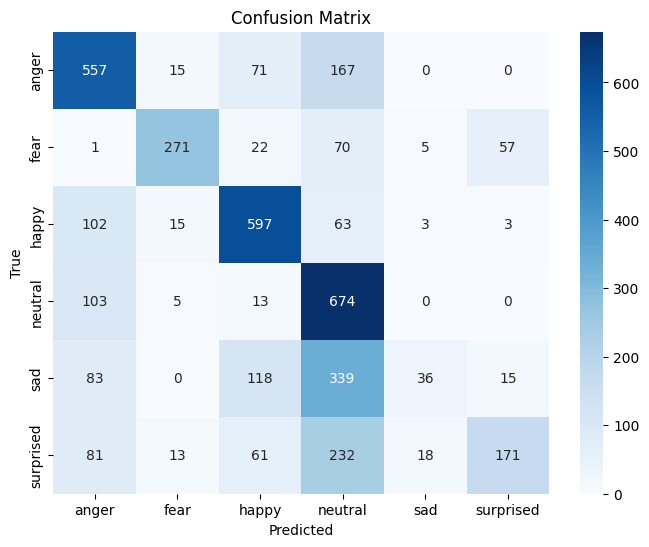

Classification Report:
              precision    recall  f1-score   support

       anger       0.60      0.69      0.64       810
        fear       0.85      0.64      0.73       426
       happy       0.68      0.76      0.72       783
     neutral       0.44      0.85      0.58       795
         sad       0.58      0.06      0.11       591
   surprised       0.70      0.30      0.42       576

    accuracy                           0.58      3981
   macro avg       0.64      0.55      0.53      3981
weighted avg       0.62      0.58      0.54      3981

Accuracy: 0.5793
Recall: 0.5793
Precision: 0.6202
F1 Score: 0.5410


In [ ]:
predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# 3D Inception-Resnet + LSTM

In [ ]:
train_dir = r"C:\Users\ACER\Downloads\dataset\split_final\train"
val_dir = r"C:\Users\ACER\Downloads\dataset\split_final\\val"
test_dir = r"C:\Users\ACER\Downloads\dataset\split_final\test"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7212 images belonging to 6 classes.
Found 2060 images belonging to 6 classes.
Found 1050 images belonging to 6 classes.


In [ ]:
print("Class indices in train_generator:")
print(train_generator.class_indices)

print("\nClass indices in val_generator:")
print(val_generator.class_indices)

print("\nClass indices in test_generator:")
print(test_generator.class_indices)

Class indices in train_generator:
{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}

Class indices in val_generator:
{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}

Class indices in test_generator:
{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}


In [10]:
class InceptionResNet3D(tf.keras.layers.Layer):
    def __init__(self, name="InceptionResNet3D"):
        super(InceptionResNet3D, self).__init__(name=name)
        self.dense_a = Dense(64, activation='relu', name=f"{name}_A")
        self.dense_b = Dense(128, activation='relu', name=f"{name}_B")
        self.dense_c = Dense(256, activation='relu', name=f"{name}_C")

    def call(self, inputs):
        x_a = self.dense_a(inputs)
        x_b = self.dense_b(inputs)
        x_c = self.dense_c(inputs)
        return tf.concat([x_a, x_b, x_c], axis=-1, name="Concat")

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

input_frame = Input(shape=(224, 224, 3), name="Input_Frame")

x = base_model(input_frame)

x = GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)

x = InceptionResNet3D(name="Block_A")(x)
x = InceptionResNet3D(name="Block_B")(x)
x = InceptionResNet3D(name="Block_C")(x)

x = Dropout(0.5, name="Dropout")(x)

x = Lambda(lambda t: tf.expand_dims(t, axis=1), name="Expand_Dims")(x)

lstm_output = LSTM(128, name="LSTM_Layer")(x)

fc = Dense(128, activation='relu', name="FC_Layer")(lstm_output)

output_layer = Dense(6, activation='softmax', name="Output_Layer")

output = output_layer(fc)

model = Model(inputs=input_frame, outputs=output, name="InceptionResNetV2_LSTM_Model")

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "InceptionResNetV2_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Frame (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Global_Avg_Pooling                   │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Block_A (InceptionResNet3D)          │ (None, 448)                 │         688,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Block_B (InceptionResNet3D)          │ (None, 448)                 │         201,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Block_C (InceptionResNet3D)          │ (None, 448)                 │         201,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Expand_Dims (Lambda)                 │ (None, 1, 448)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 128)                 │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,740,326 (212.63 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [12]:
checkpoint_callback = ModelCheckpoint(
    filepath='model.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3970 - loss: 1.4589
Epoch 1: val_accuracy improved from -inf to 0.84187, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 782s 4s/step - accuracy: 0.3979 - loss: 1.4568 - val_accuracy: 0.8419 - val_loss: 0.3944
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8724 - loss: 0.3564
Epoch 2: val_accuracy improved from 0.84187 to 0.93009, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 773s 4s/step - accuracy: 0.8725 - loss: 0.3561 - val_accuracy: 0.9301 - val_loss: 0.1939
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9557 - loss: 0.1331
Epoch 3: val_accuracy improved from 0.93009 to 0.96785, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.9556 - loss: 0.1331 - val_accuracy: 0.9679 - val_loss: 0.0944
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9722 - loss: 0.0919
Epoch 4: val_accuracy improved from 0.9678

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9957 - loss: 0.0162
Test Loss: 0.018180424347519875
Test Accuracy: 0.9952273368835449


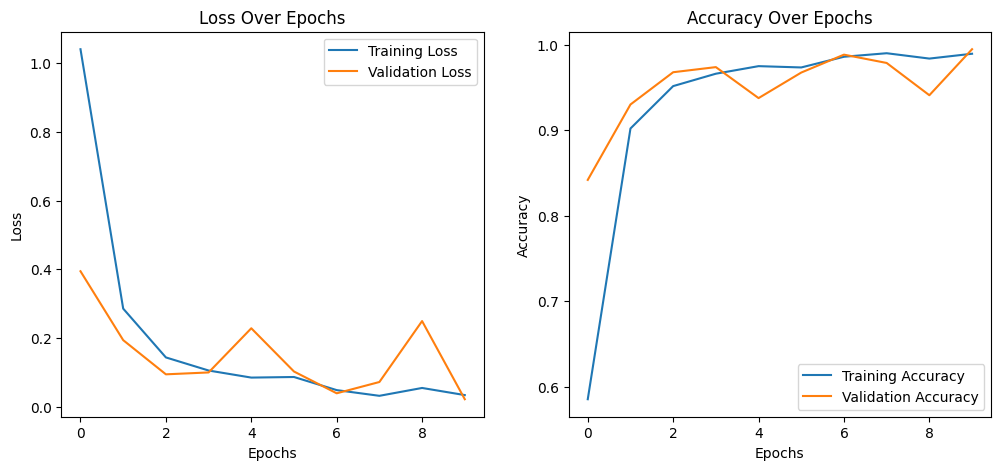

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step

Generating Confusion Matrix and Classification Report...


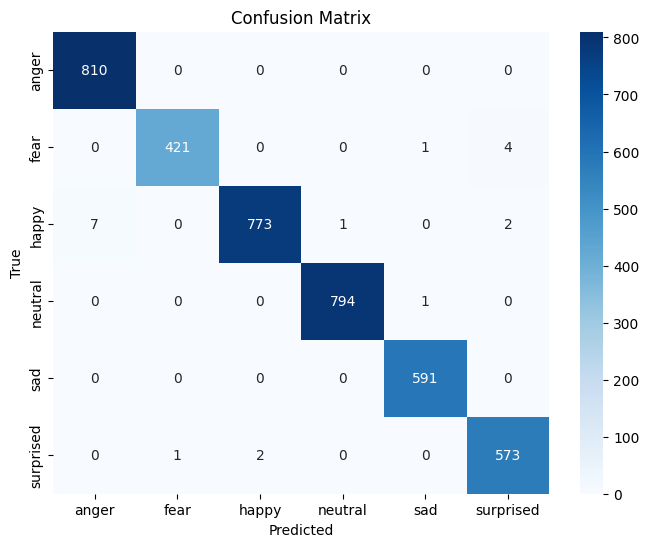

Classification Report:
              precision    recall  f1-score   support

       anger       0.99      1.00      1.00       810
        fear       1.00      0.99      0.99       426
       happy       1.00      0.99      0.99       783
     neutral       1.00      1.00      1.00       795
         sad       1.00      1.00      1.00       591
   surprised       0.99      0.99      0.99       576

    accuracy                           1.00      3981
   macro avg       1.00      0.99      1.00      3981
weighted avg       1.00      1.00      1.00      3981

Accuracy: 0.9952
Recall: 0.9952
Precision: 0.9952
F1 Score: 0.9952


In [ ]:
predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
model.save(r"C:\Users\ACER\Downloads\dataset\fer_3dir_lstm2.keras")
print("Model training selesai dan disimpan sebagai fer_3dir.keras")

Model training selesai dan disimpan sebagai fer_3dir.keras


### Skenario 2: epoch

#### epoch 1

In [ ]:
history = model.fit(
    train_generator,
    epochs=1,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3529 - loss: 1.5066
Epoch 1: val_accuracy improved from -inf to 0.79178, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 743s 4s/step - accuracy: 0.3538 - loss: 1.5049 - val_accuracy: 0.7918 - val_loss: 0.4790


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9087 - loss: 0.2556
Test Loss: 0.4578632414340973
Test Accuracy: 0.7930168509483337


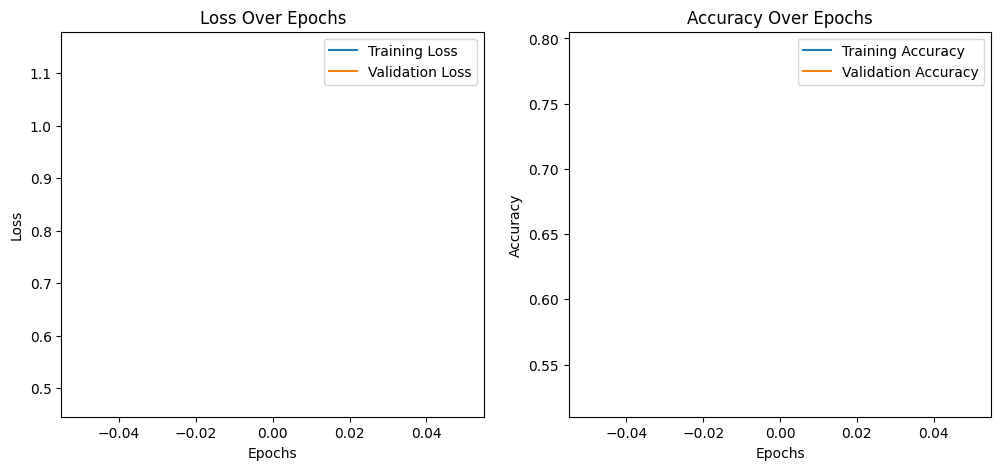

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step

Generating Confusion Matrix and Classification Report...


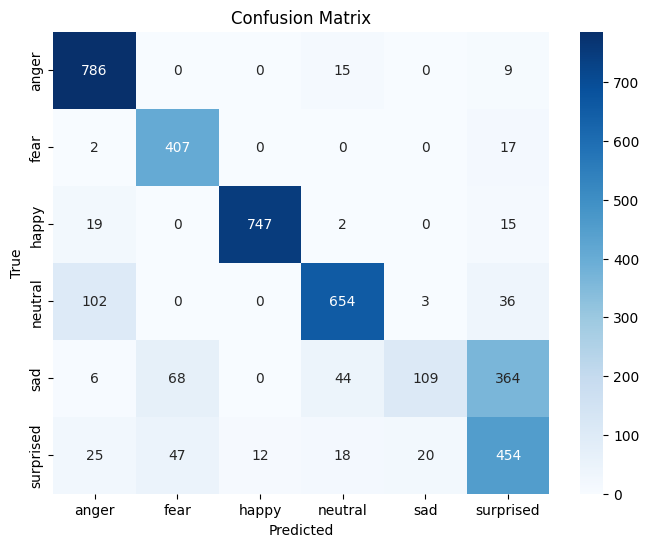

Classification Report:
              precision    recall  f1-score   support

       anger       0.84      0.97      0.90       810
        fear       0.78      0.96      0.86       426
       happy       0.98      0.95      0.97       783
     neutral       0.89      0.82      0.86       795
         sad       0.83      0.18      0.30       591
   surprised       0.51      0.79      0.62       576

    accuracy                           0.79      3981
   macro avg       0.80      0.78      0.75      3981
weighted avg       0.82      0.79      0.77      3981

Accuracy: 0.7930
Recall: 0.7930
Precision: 0.8213
F1 Score: 0.7702


In [ ]:
predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

#### epoch 3

In [ ]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

Epoch 1/3


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3735 - loss: 1.4726
Epoch 1: val_accuracy improved from -inf to 0.84561, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 721s 3s/step - accuracy: 0.3743 - loss: 1.4709 - val_accuracy: 0.8456 - val_loss: 0.4412
Epoch 2/3
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8669 - loss: 0.3863
Epoch 2: val_accuracy improved from 0.84561 to 0.93981, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 736s 4s/step - accuracy: 0.8671 - loss: 0.3859 - val_accuracy: 0.9398 - val_loss: 0.1878
Epoch 3/3
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9429 - loss: 0.1829
Epoch 3: val_accuracy improved from 0.93981 to 0.95402, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 786s 4s/step - accuracy: 0.9429 - loss: 0.1828 - val_accuracy: 0.9540 - val_loss: 0.1598


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9747 - loss: 0.0868
Test Loss: 0.13951608538627625
Test Accuracy: 0.9547852277755737


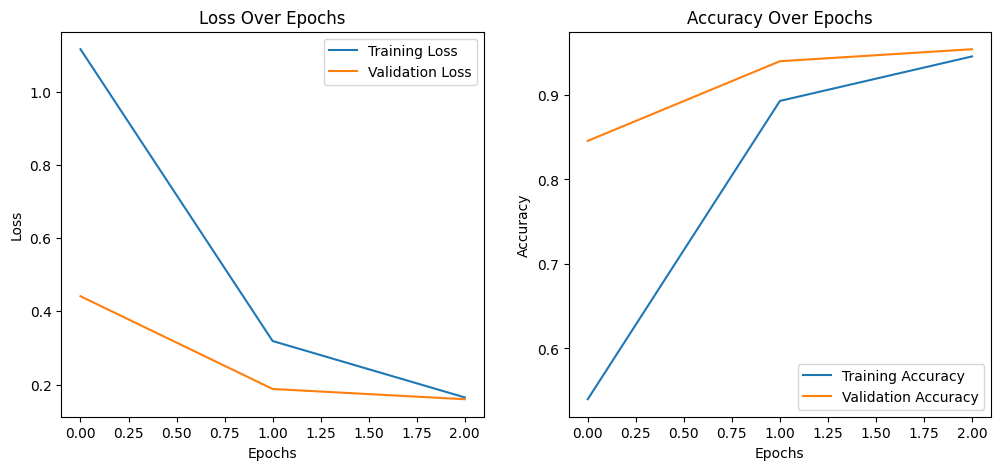

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step

Generating Confusion Matrix and Classification Report...


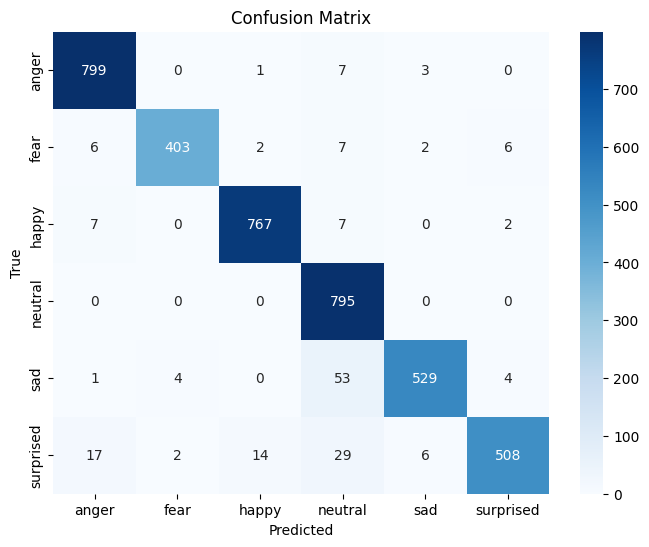

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.99      0.97       810
        fear       0.99      0.95      0.97       426
       happy       0.98      0.98      0.98       783
     neutral       0.89      1.00      0.94       795
         sad       0.98      0.90      0.94       591
   surprised       0.98      0.88      0.93       576

    accuracy                           0.95      3981
   macro avg       0.96      0.95      0.95      3981
weighted avg       0.96      0.95      0.95      3981

Accuracy: 0.9548
Recall: 0.9548
Precision: 0.9573
F1 Score: 0.9546


In [ ]:
predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


#### epoch 5

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

Epoch 1/5


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4029 - loss: 1.4236
Epoch 1: val_accuracy improved from -inf to 0.87439, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 770s 4s/step - accuracy: 0.4038 - loss: 1.4217 - val_accuracy: 0.8744 - val_loss: 0.3705
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8679 - loss: 0.3616
Epoch 2: val_accuracy improved from 0.87439 to 0.91664, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 749s 4s/step - accuracy: 0.8680 - loss: 0.3613 - val_accuracy: 0.9166 - val_loss: 0.2125
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9495 - loss: 0.1504
Epoch 3: val_accuracy improved from 0.91664 to 0.96486, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 746s 4s/step - accuracy: 0.9495 - loss: 0.1503 - val_accuracy: 0.9649 - val_loss: 0.1064
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9504 - loss: 0.1443
Epoch 4: val_accuracy did not improve from 0.96486
205/2

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9563 - loss: 0.1122
Test Loss: 0.04987689107656479
Test Accuracy: 0.9819141030311584


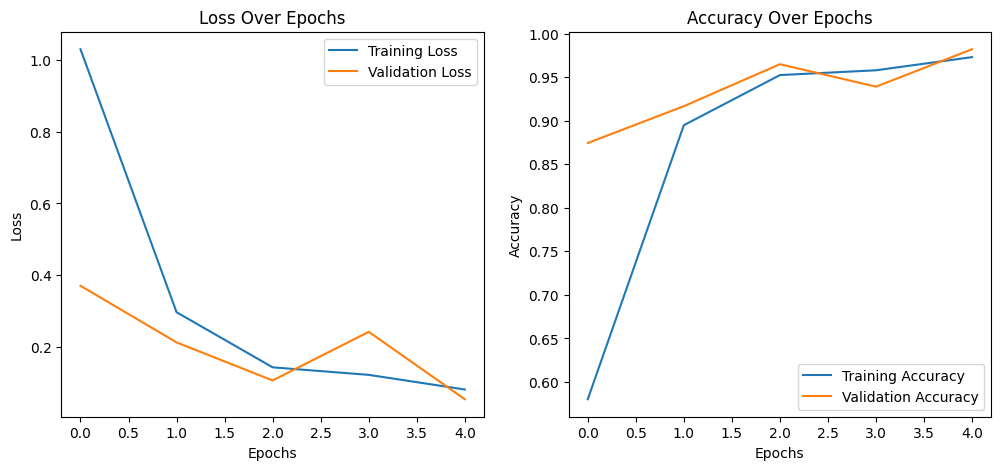

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step

Generating Confusion Matrix and Classification Report...


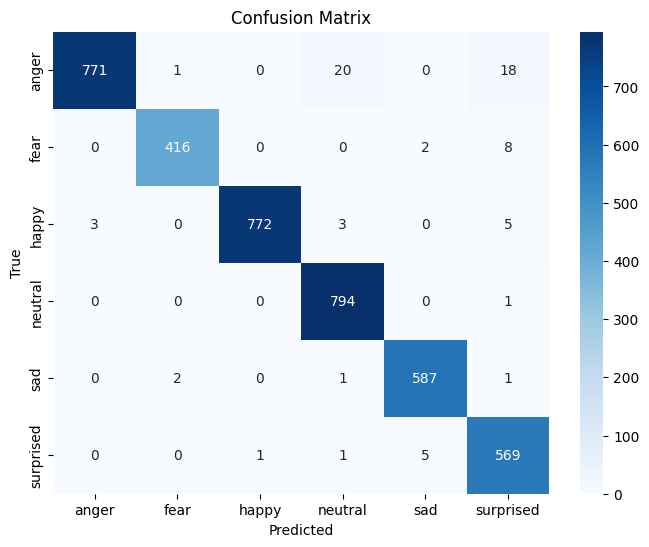

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.95      0.97       810
        fear       0.99      0.98      0.98       426
       happy       1.00      0.99      0.99       783
     neutral       0.97      1.00      0.98       795
         sad       0.99      0.99      0.99       591
   surprised       0.95      0.99      0.97       576

    accuracy                           0.98      3981
   macro avg       0.98      0.98      0.98      3981
weighted avg       0.98      0.98      0.98      3981

Accuracy: 0.9819
Recall: 0.9819
Precision: 0.9824
F1 Score: 0.9819


In [ ]:
predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


### Skenario 3: batch size

#### 4

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=False
)

Found 7212 images belonging to 6 classes.
Found 2060 images belonging to 6 classes.
Found 1050 images belonging to 6 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

Epoch 1/5


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1638/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.1971 - loss: 1.7958
Epoch 1: val_accuracy improved from -inf to 0.19626, saving model to model.weights.h5
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 1023s 610ms/step - accuracy: 0.1971 - loss: 1.7958 - val_accuracy: 0.1963 - val_loss: 1.7764
Epoch 2/5
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.1939 - loss: 1.7767
Epoch 2: val_accuracy did not improve from 0.19626
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 1006s 614ms/step - accuracy: 0.1939 - loss: 1.7767 - val_accuracy: 0.1963 - val_loss: 1.7709
Epoch 3/5
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.1980 - loss: 1.7725
Epoch 3: val_accuracy did not improve from 0.19626
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 920s 562ms/step - accuracy: 0.1980 - loss: 1.7725 - val_accuracy: 0.1963 - val_loss: 1.7723
Epoch 4/5
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.2095 - loss: 1.7740
Epoch 4: val_accuracy did not improve from 0.19626
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 936s 572ms/st

996/996 ━━━━━━━━━━━━━━━━━━━━ 447s 449ms/step - accuracy: 0.5265 - loss: 1.7167
Test Loss: 1.769372582435608
Test Accuracy: 0.20346646010875702


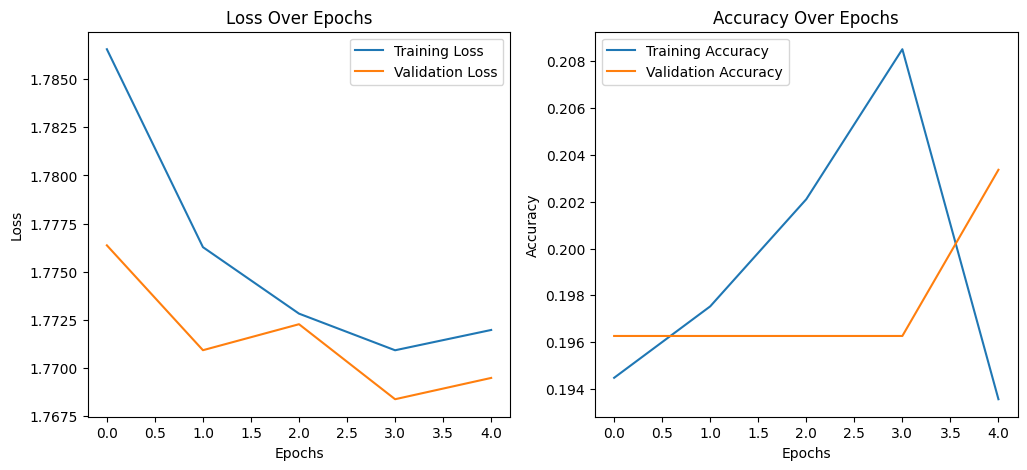

996/996 ━━━━━━━━━━━━━━━━━━━━ 461s 455ms/step

Generating Confusion Matrix and Classification Report...


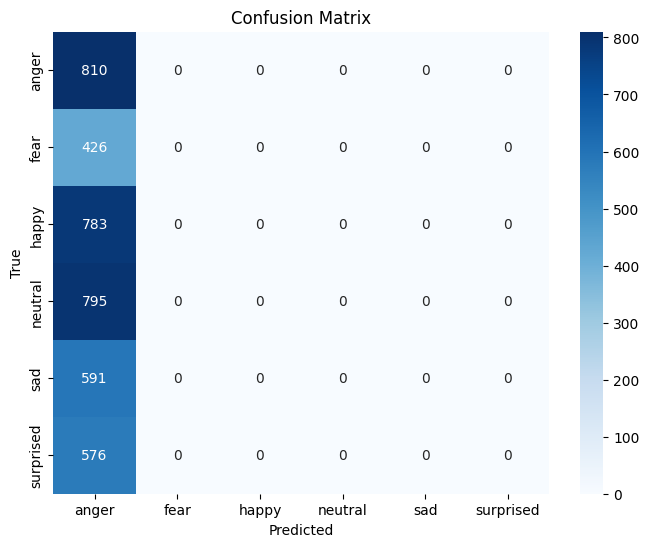

Classification Report:
              precision    recall  f1-score   support

       anger       0.20      1.00      0.34       810
        fear       0.00      0.00      0.00       426
       happy       0.00      0.00      0.00       783
     neutral       0.00      0.00      0.00       795
         sad       0.00      0.00      0.00       591
   surprised       0.00      0.00      0.00       576

    accuracy                           0.20      3981
   macro avg       0.03      0.17      0.06      3981
weighted avg       0.04      0.20      0.07      3981

Accuracy: 0.2035
Recall: 0.2035
Precision: 0.0414
F1 Score: 0.0688


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

#### 8

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

Found 7212 images belonging to 6 classes.
Found 2060 images belonging to 6 classes.
Found 1050 images belonging to 6 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

Epoch 1/5


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.2441 - loss: 1.7218
Epoch 1: val_accuracy improved from -inf to 0.61533, saving model to model.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 876s 1s/step - accuracy: 0.2442 - loss: 1.7216 - val_accuracy: 0.6153 - val_loss: 0.9853
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.7183 - loss: 0.7222
Epoch 2: val_accuracy improved from 0.61533 to 0.79813, saving model to model.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 849s 1s/step - accuracy: 0.7184 - loss: 0.7220 - val_accuracy: 0.7981 - val_loss: 0.6519
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.8637 - loss: 0.3905
Epoch 3: val_accuracy improved from 0.79813 to 0.88449, saving model to model.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 850s 1s/step - accuracy: 0.8637 - loss: 0.3904 - val_accuracy: 0.8845 - val_loss: 0.3717
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.9192 - loss: 0.2320
Epoch 4: val_accuracy improved from 0.88449 

498/498 ━━━━━━━━━━━━━━━━━━━━ 358s 719ms/step - accuracy: 0.9753 - loss: 0.1019
Test Loss: 0.12121261656284332
Test Accuracy: 0.9635769724845886


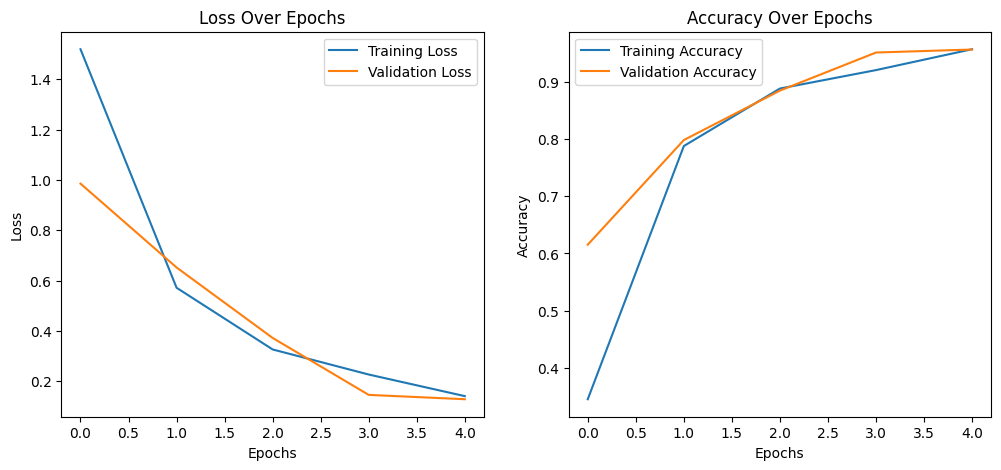

498/498 ━━━━━━━━━━━━━━━━━━━━ 372s 736ms/step

Generating Confusion Matrix and Classification Report...


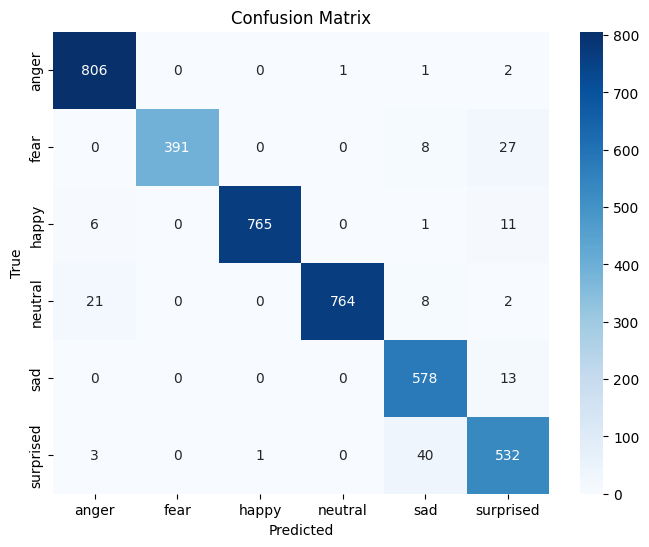

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      1.00      0.98       810
        fear       1.00      0.92      0.96       426
       happy       1.00      0.98      0.99       783
     neutral       1.00      0.96      0.98       795
         sad       0.91      0.98      0.94       591
   surprised       0.91      0.92      0.91       576

    accuracy                           0.96      3981
   macro avg       0.96      0.96      0.96      3981
weighted avg       0.97      0.96      0.96      3981

Accuracy: 0.9636
Recall: 0.9636
Precision: 0.9651
F1 Score: 0.9638


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

#### 16

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 7212 images belonging to 6 classes.
Found 2060 images belonging to 6 classes.
Found 1050 images belonging to 6 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

Epoch 1/5


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3778 - loss: 1.4559
Epoch 1: val_accuracy improved from -inf to 0.77047, saving model to model.weights.h5
410/410 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.3781 - loss: 1.4551 - val_accuracy: 0.7705 - val_loss: 0.6100
Epoch 2/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8202 - loss: 0.4716
Epoch 2: val_accuracy improved from 0.77047 to 0.88822, saving model to model.weights.h5
410/410 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - accuracy: 0.8203 - loss: 0.4714 - val_accuracy: 0.8882 - val_loss: 0.2962
Epoch 3/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9215 - loss: 0.2257
Epoch 3: val_accuracy improved from 0.88822 to 0.91103, saving model to model.weights.h5
410/410 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.9215 - loss: 0.2256 - val_accuracy: 0.9110 - val_loss: 0.2793
Epoch 4/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9557 - loss: 0.1427
Epoch 4: val_accuracy improved from 0.91103 to 0.95888, 

249/249 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9883 - loss: 0.0450
Test Loss: 0.054053232073783875
Test Accuracy: 0.9849284291267395


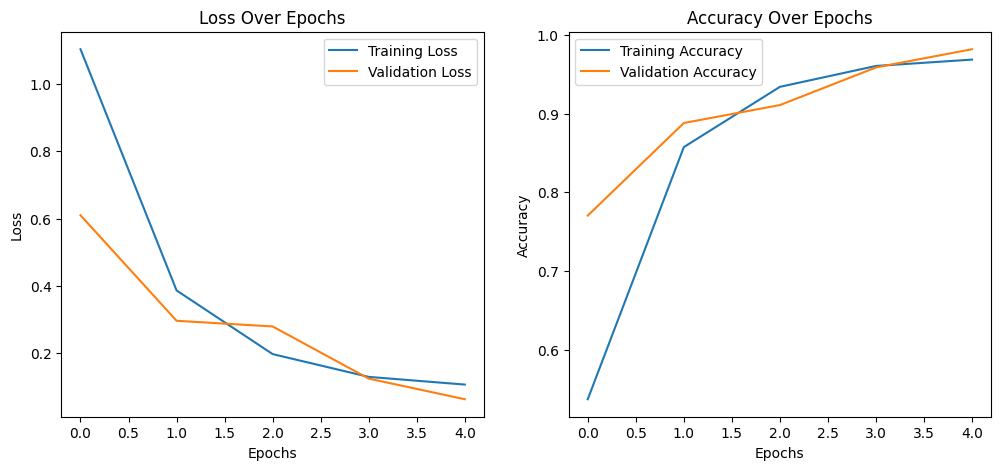

249/249 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step

Generating Confusion Matrix and Classification Report...


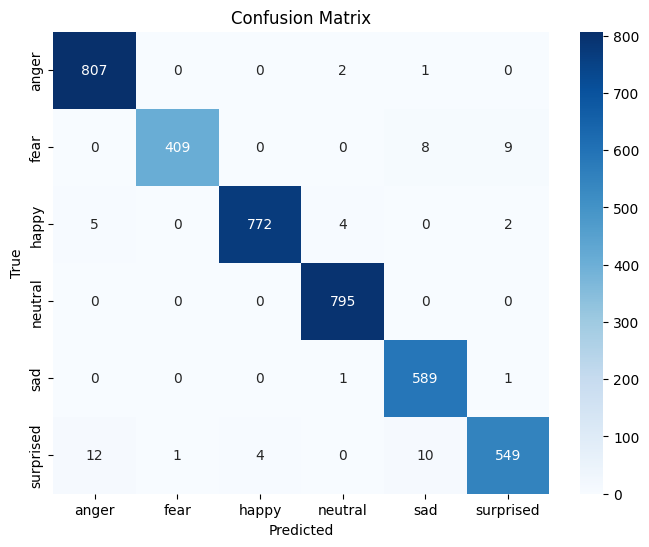

Classification Report:
              precision    recall  f1-score   support

       anger       0.98      1.00      0.99       810
        fear       1.00      0.96      0.98       426
       happy       0.99      0.99      0.99       783
     neutral       0.99      1.00      1.00       795
         sad       0.97      1.00      0.98       591
   surprised       0.98      0.95      0.97       576

    accuracy                           0.98      3981
   macro avg       0.99      0.98      0.98      3981
weighted avg       0.99      0.98      0.98      3981

Accuracy: 0.9849
Recall: 0.9849
Precision: 0.9851
F1 Score: 0.9849


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

### Skenario 4: Learning rate

#### learning rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3784 - loss: 1.6030
Epoch 1: val_accuracy improved from -inf to 0.75589, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 0.3791 - loss: 1.6018 - val_accuracy: 0.7559 - val_loss: 0.6919
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8182 - loss: 0.6097
Epoch 2: val_accuracy improved from 0.75589 to 0.94056, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 728s 4s/step - accuracy: 0.8184 - loss: 0.6090 - val_accuracy: 0.9406 - val_loss: 0.2034
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9542 - loss: 0.2001
Epoch 3: val_accuracy improved from 0.94056 to 0.97383, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 695s 3s/step - accuracy: 0.9543 - loss: 0.1999 - val_accuracy: 0.9738 - val_loss: 0.0884
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9752 - loss: 0.0918
Epoch 4: val_accuracy improved from 0.97383 to

125/125 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9946 - loss: 0.0183
Test Loss: 0.05773233622312546
Test Accuracy: 0.983421266078949


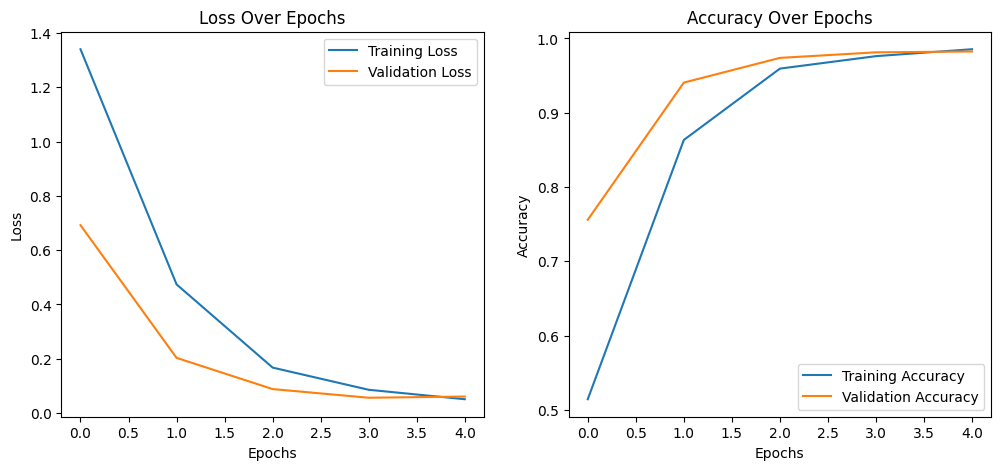

125/125 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step

Generating Confusion Matrix and Classification Report...


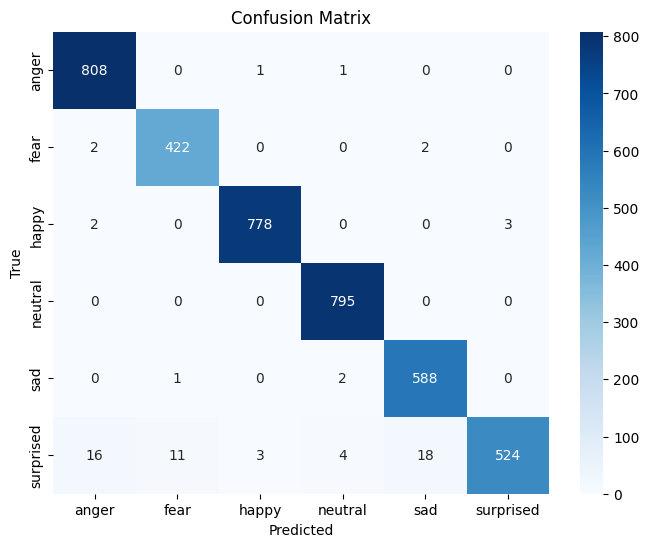

Classification Report:
              precision    recall  f1-score   support

       anger       0.98      1.00      0.99       810
        fear       0.97      0.99      0.98       426
       happy       0.99      0.99      0.99       783
     neutral       0.99      1.00      1.00       795
         sad       0.97      0.99      0.98       591
   surprised       0.99      0.91      0.95       576

    accuracy                           0.98      3981
   macro avg       0.98      0.98      0.98      3981
weighted avg       0.98      0.98      0.98      3981

Accuracy: 0.9834
Recall: 0.9834
Precision: 0.9837
F1 Score: 0.9832


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.show()

# Generate predictions
predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

# Confusion Matrix, Precision, Recall, F1-Score
print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

#### learning rate = 0.00001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

Epoch 1/5


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2485 - loss: 1.7704
Epoch 1: val_accuracy improved from -inf to 0.41869, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.2487 - loss: 1.7703 - val_accuracy: 0.4187 - val_loss: 1.6971
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3527 - loss: 1.6993
Epoch 2: val_accuracy improved from 0.41869 to 0.50766, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 721s 4s/step - accuracy: 0.3529 - loss: 1.6991 - val_accuracy: 0.5077 - val_loss: 1.5778
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4647 - loss: 1.5899
Epoch 3: val_accuracy improved from 0.50766 to 0.56710, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 721s 4s/step - accuracy: 0.4648 - loss: 1.5897 - val_accuracy: 0.5671 - val_loss: 1.3980
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5412 - loss: 1.4289
Epoch 4: val_accuracy improved from 0.56710 to 0.63963, 

125/125 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7916 - loss: 0.8194
Test Loss: 0.9743642807006836
Test Accuracy: 0.70359206199646


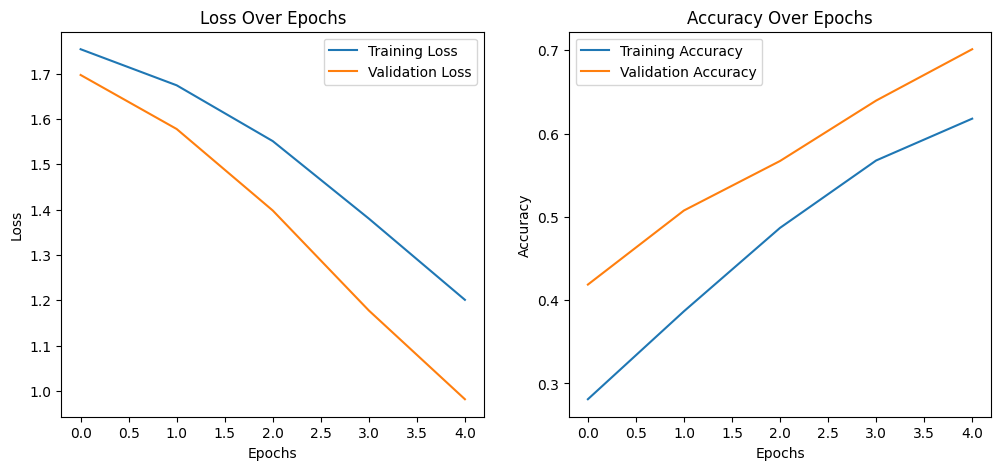

125/125 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step

Generating Confusion Matrix and Classification Report...


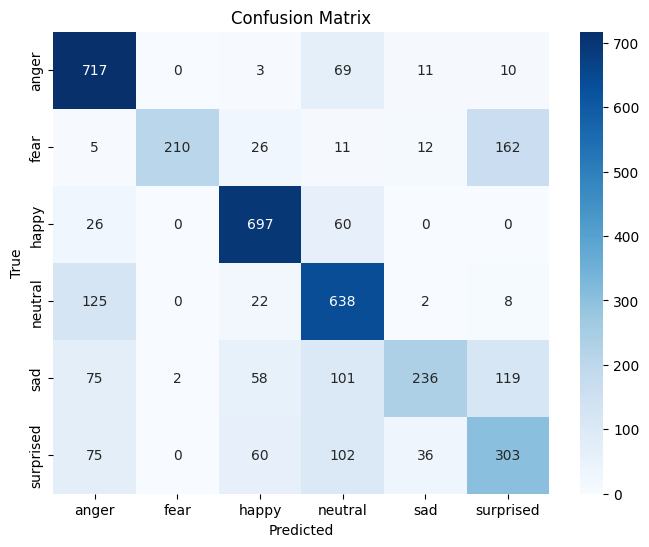

Classification Report:
              precision    recall  f1-score   support

       anger       0.70      0.89      0.78       810
        fear       0.99      0.49      0.66       426
       happy       0.80      0.89      0.85       783
     neutral       0.65      0.80      0.72       795
         sad       0.79      0.40      0.53       591
   surprised       0.50      0.53      0.51       576

    accuracy                           0.70      3981
   macro avg       0.74      0.67      0.68      3981
weighted avg       0.73      0.70      0.69      3981

Accuracy: 0.7036
Recall: 0.7036
Precision: 0.7276
F1 Score: 0.6927


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

#### learning rate = 0.000001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1227 - loss: 1.8015
Epoch 1: val_accuracy improved from -inf to 0.11364, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1464s 7s/step - accuracy: 0.1227 - loss: 1.8014 - val_accuracy: 0.1136 - val_loss: 1.7918
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1499 - loss: 1.7910
Epoch 2: val_accuracy improved from 0.11364 to 0.22393, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1129s 6s/step - accuracy: 0.1500 - loss: 1.7909 - val_accuracy: 0.2239 - val_loss: 1.7796
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1927 - loss: 1.7788
Epoch 3: val_accuracy improved from 0.22393 to 0.31589, saving model to model.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1127s 6s/step - accuracy: 0.1927 - loss: 1.7788 - val_accuracy: 0.3159 - val_loss: 1.7689
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2385 - loss: 1.7707
Epoch 4: val_accuracy improved from 0.31589

125/125 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.5973 - loss: 1.6961
Test Loss: 1.7494351863861084
Test Accuracy: 0.37076112627983093


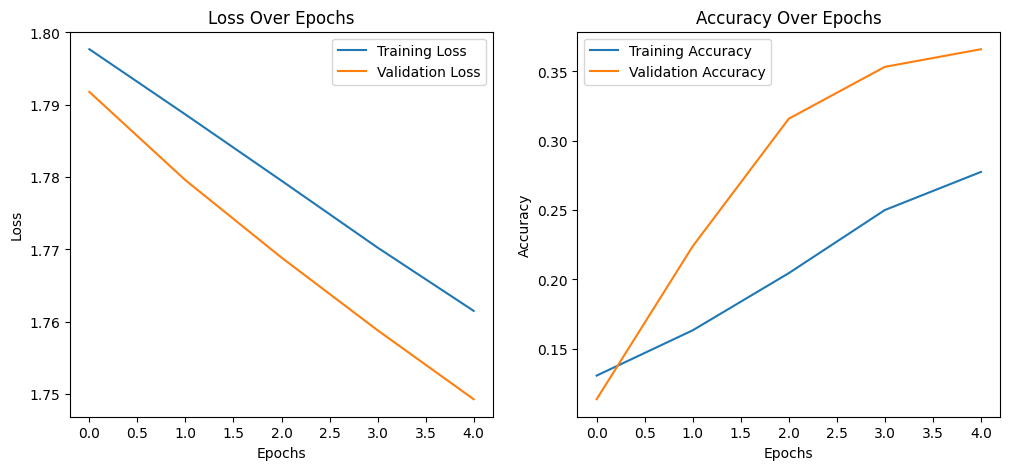

125/125 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step

Generating Confusion Matrix and Classification Report...


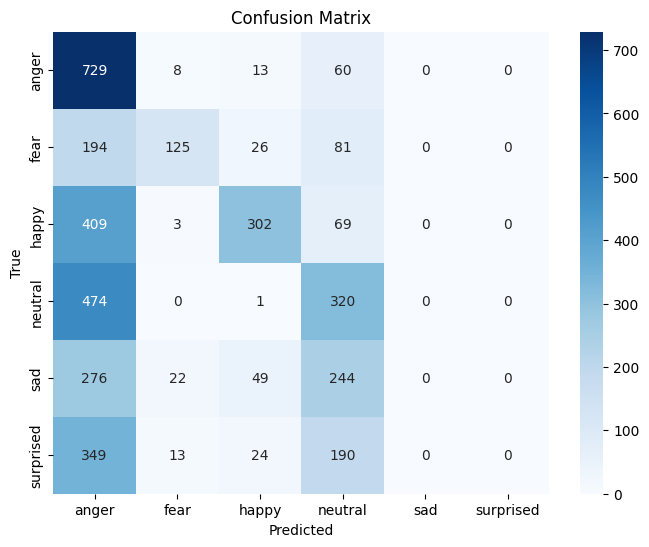

Classification Report:
              precision    recall  f1-score   support

       anger       0.30      0.90      0.45       810
        fear       0.73      0.29      0.42       426
       happy       0.73      0.39      0.50       783
     neutral       0.33      0.40      0.36       795
         sad       0.00      0.00      0.00       591
   surprised       0.00      0.00      0.00       576

    accuracy                           0.37      3981
   macro avg       0.35      0.33      0.29      3981
weighted avg       0.35      0.37      0.31      3981

Accuracy: 0.3708
Recall: 0.3708
Precision: 0.3487
F1 Score: 0.3082


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

### Optimalisasi hyperparameter

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 7212 images belonging to 6 classes.
Found 2060 images belonging to 6 classes.
Found 1050 images belonging to 6 classes.


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint_callback]
)

C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4281 - loss: 1.4775
Epoch 1: val_accuracy improved from -inf to 0.87028, saving model to model.weights.h5
410/410 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.4285 - loss: 1.4766 - val_accuracy: 0.8703 - val_loss: 0.4134
Epoch 2/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8919 - loss: 0.3593
Epoch 2: val_accuracy improved from 0.87028 to 0.97159, saving model to model.weights.h5
410/410 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.8920 - loss: 0.3590 - val_accuracy: 0.9716 - val_loss: 0.1064
Epoch 3/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9666 - loss: 0.1192
Epoch 3: val_accuracy improved from 0.97159 to 0.97869, saving model to model.weights.h5
410/410 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - accuracy: 0.9666 - loss: 0.1191 - val_accuracy: 0.9787 - val_loss: 0.0630
Epoch 4/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9823 - loss: 0.0627
Epoch 4: val_accuracy improved from 0.97869 to

249/249 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.9962 - loss: 0.0120
Test Loss: 0.029915854334831238
Test Accuracy: 0.9907058477401733


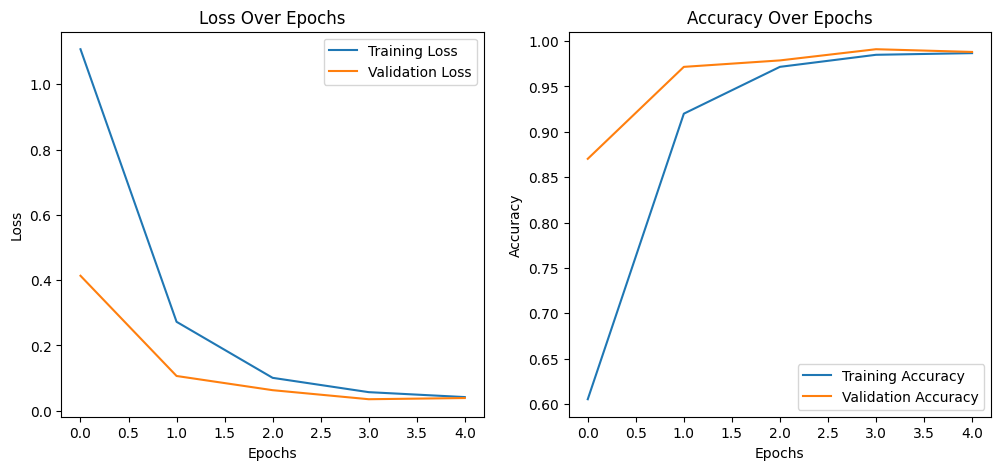

249/249 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step

Generating Confusion Matrix and Classification Report...


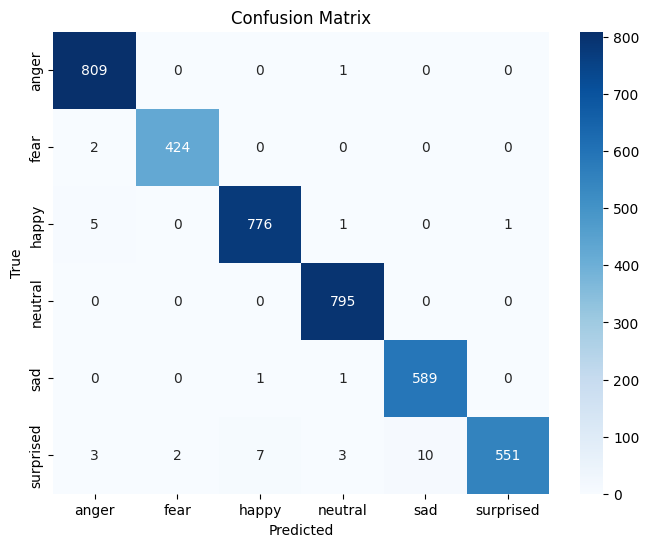

Classification Report:
              precision    recall  f1-score   support

       anger       0.99      1.00      0.99       810
        fear       1.00      1.00      1.00       426
       happy       0.99      0.99      0.99       783
     neutral       0.99      1.00      1.00       795
         sad       0.98      1.00      0.99       591
   surprised       1.00      0.96      0.98       576

    accuracy                           0.99      3981
   macro avg       0.99      0.99      0.99      3981
weighted avg       0.99      0.99      0.99      3981

Accuracy: 0.9907
Recall: 0.9907
Precision: 0.9908
F1 Score: 0.9907


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

predictions = model.predict(test_generator)
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)

print("\nGenerating Confusion Matrix and Classification Report...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

In [15]:
model.save(r"C:\Users\ACER\Downloads\dataset\fer_3dir_lstm_final.keras")
print("Model training selesai dan disimpan sebagai fer_3dir_lstm_final.keras")

Model training selesai dan disimpan sebagai fer_3dir_lstm_final.keras


# Real-time FER 3D Inception-Resnet + LSTM

In [16]:
model_path = r"C:\Users\ACER\Downloads\dataset\fer_3dir_lstm_final.keras"

In [17]:
class InceptionResNet3D(tf.keras.layers.Layer):
    def __init__(self, name="InceptionResNet3D"):
        super(InceptionResNet3D, self).__init__(name=name)
        self.dense_a = Dense(64, activation='relu', name=f"{name}_A")
        self.dense_b = Dense(128, activation='relu', name=f"{name}_B")
        self.dense_c = Dense(256, activation='relu', name=f"{name}_C")

    def call(self, inputs):
        x_a = self.dense_a(inputs)
        x_b = self.dense_b(inputs)
        x_c = self.dense_c(inputs)
        return tf.concat([x_a, x_b, x_c], axis=-1, name="Concat")

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

input_frame = Input(shape=(224, 224, 3), name="Input_Frame")

x = base_model(input_frame)

x = GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)

x = InceptionResNet3D(name="Block_A")(x)
x = InceptionResNet3D(name="Block_B")(x)
x = InceptionResNet3D(name="Block_C")(x)

x = Dropout(0.5, name="Dropout")(x)

x = Lambda(lambda t: tf.expand_dims(t, axis=1), name="Expand_Dims")(x)

lstm_output = LSTM(128, name="LSTM_Layer")(x)

fc = Dense(128, activation='relu', name="FC_Layer")(lstm_output)

output_layer = Dense(6, activation='softmax', name="Output_Layer")

output = output_layer(fc)

custom_model = Model(inputs=input_frame, outputs=output, name="3DInceptionResNetV2_LSTM_Model")

custom_model.load_weights(model_path)

In [18]:
# Mapping ekspresi ke kategori ketertarikan
expression_to_interest = {
    'neutral': 'attentive',
    'happy': 'attentive',
    'surprised': 'attentive',
    'sad': 'inattentive',
    'anger': 'inattentive',
    'fear': 'inattentive'
}

# Label ekspresi
expressions = ['anger', 'fear', 'happy', 'neutral', 'sad', 'surprised']

In [19]:
# Fungsi untuk mendeteksi wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


def preprocess_frame(frame, target_size=(224, 224)):
    face = cv2.resize(frame, target_size)
    face = face / 255.0
    face = np.expand_dims(face, axis=0)
    return face

# Real-time video capture
cap = cv2.VideoCapture(0)  # 0 untuk kamera bawaan
if not cap.isOpened():
    print("Error accessing the camera.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            preprocessed_face = preprocess_frame(face)

            # Prediksi ekspresi
            predictions = custom_model.predict(preprocessed_face)
            predicted_label = np.argmax(predictions)
            predicted_expression = expressions[predicted_label]
            interest = expression_to_interest[predicted_expression]

            # Warna bounding box berdasarkan ketertarikan
            color = (0, 255, 0) if interest == 'attentive' else (0, 0, 255)

            # Tambahkan bounding box dan teks
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            text = f"{predicted_expression} ({interest})"
            cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Tampilkan frame
        cv2.imshow('Real-time Facial Expression Recognition', frame)

        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 